In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import optuna

/app/tmp1/anaconda/envs/nse-torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import re

In [3]:
from perform_visualization import perform_eda, perform_eda_short, performance_visualizations

In [4]:
random_seed = 42
early_stopping_round = 100

In [11]:
stat_path = os.path.join(os.getcwd())
pattern = re.compile(r'output_*\d')
folder_paths =[]
for folder_name in os.listdir(stat_path):
    if pattern.match(folder_name):
        folder_paths.append(folder_name)

In [12]:
specific_features= pd.DataFrame({"y": [500.0],
                                "z": [156.25],
                                "u": [7.5],
                                "power":[1.1],
                                "roughness": [0.1],
                                "T": [241.0],
                                "sensible_heat_flux":[-0.35],
                                "T_grad":[0.03],
                                "distances": [1054.6875]})

In [13]:
filename_features = "features_full.csv"
filename_target = "target_full.csv"

In [14]:
folder_paths = ["output_19_01_2025_2"]

In [17]:
X = pd.DataFrame()
y = pd.DataFrame()
for folder in folder_paths:
    X_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_features)
    y_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_target)
    
    is_unnamed = pd.isna(X_tmp.columns[0]) or str(X_tmp.columns[0]).startswith('Unnamed:')
    is_unnamed_y = pd.isna(y_tmp.columns[0]) or str(y_tmp.columns[0]).startswith('Unnamed:')
    if is_unnamed:
        X_tmp = X_tmp.drop(X_tmp.columns[0], axis=1)
    if is_unnamed_y:
        y_tmp = y_tmp.drop(y_tmp.columns[0], axis=1)
    
    # if X_tmp.columns[0] != "y":
    #     col_y = np.ones(X_tmp.shape[0]) * 1000
    #     X_tmp.insert(0, "y", col_y)
    
    print(X_tmp.shape, y_tmp.shape)
    X = pd.concat([X, X_tmp], axis = 0)
    y = pd.concat([y, y_tmp], axis = 0)
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
X.shape, y.shape

(2322432, 10) (2322432, 4)


((2322432, 10), (2322432, 4))

In [23]:
X.drop(columns="Tracer", inplace=True)

## EDA

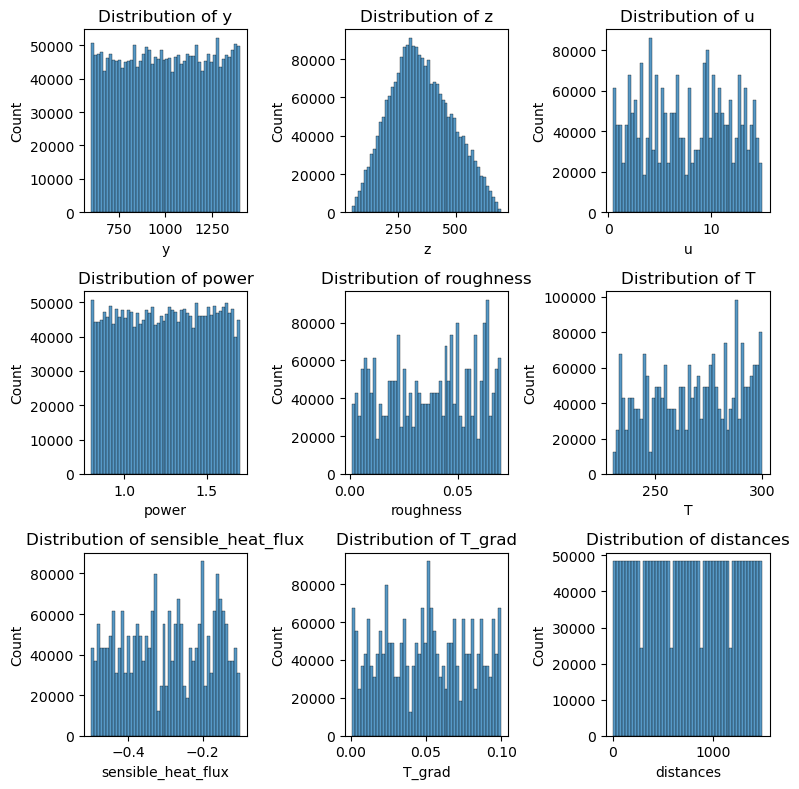

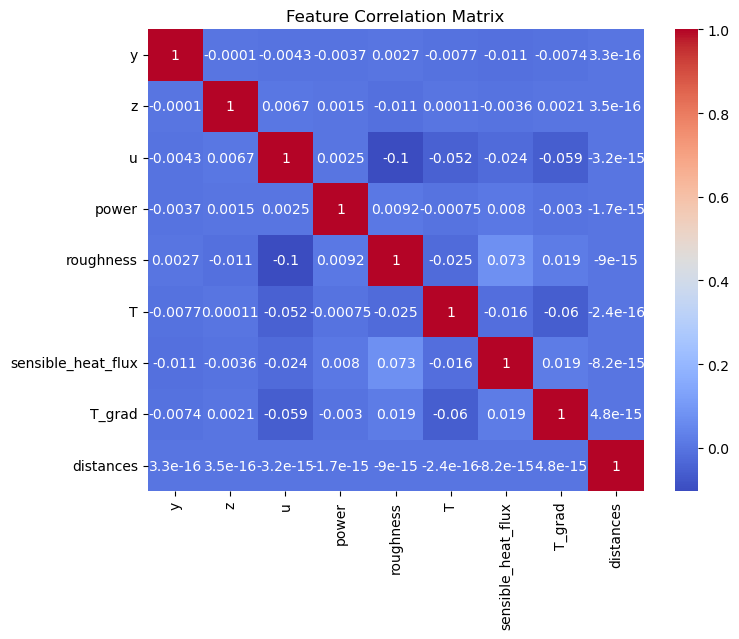

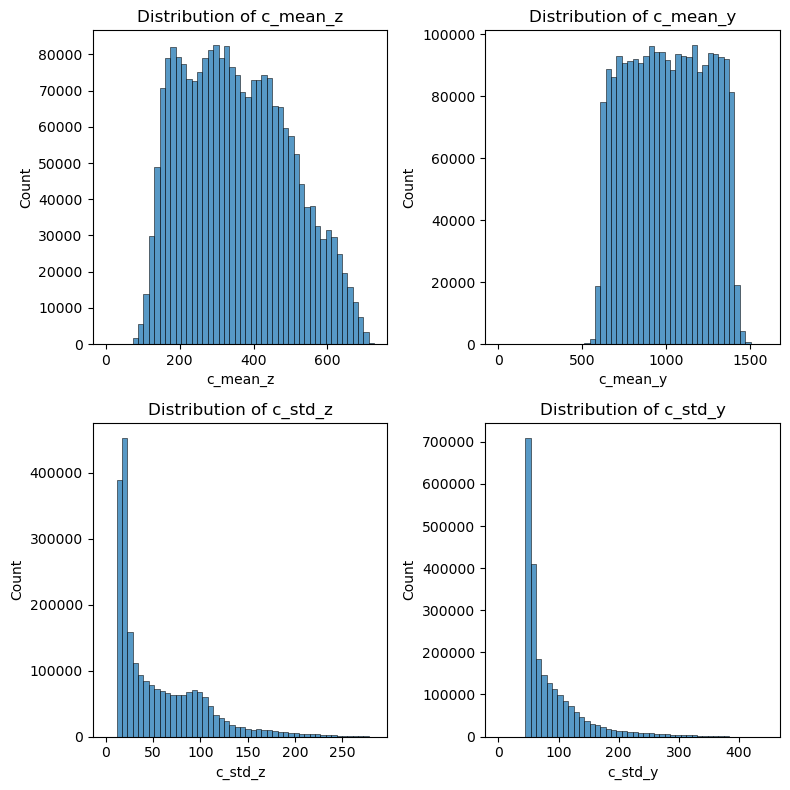

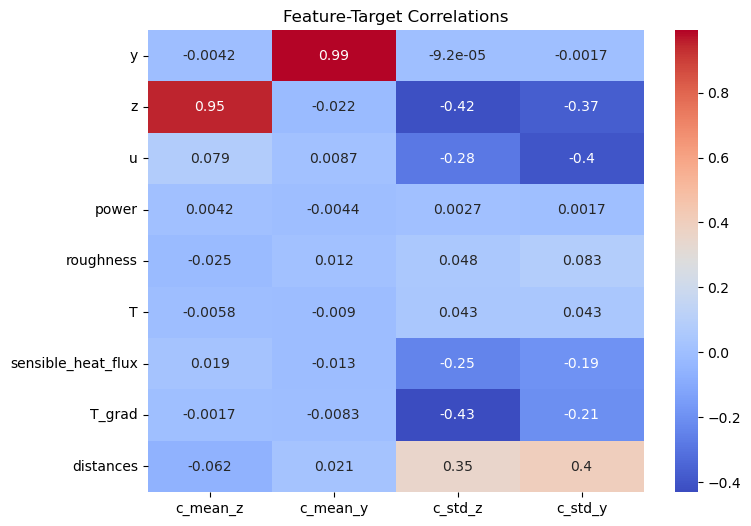

In [24]:
perform_eda(X, y)

In [26]:
#Delete zeros
mask = (y["c_std_y"] != 0) & (y["c_std_z"] != 0)
X = X[mask]
y = y[mask]

In [27]:
points = np.linspace(0, np.max(y["c_std_y"]), 200)
quantiles = np.histogram(y["c_std_y"], points)
hist_mode = quantiles[1][np.argmax(quantiles[0])]
cut_mask = y["c_std_y"] >= hist_mode
X = X[cut_mask]
y = y[cut_mask]
X.shape, y.shape

((2312849, 9), (2312849, 4))

## Test-train split

In [28]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

In [13]:
# for small dataset
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [14]:
# for small dataset
X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

((596090, 9), (596090, 4), (66233, 9), (66233, 4))

In [15]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

((596090, 9), (596090, 4), (165581, 9), (165581, 4), (66233, 9), (66233, 4))

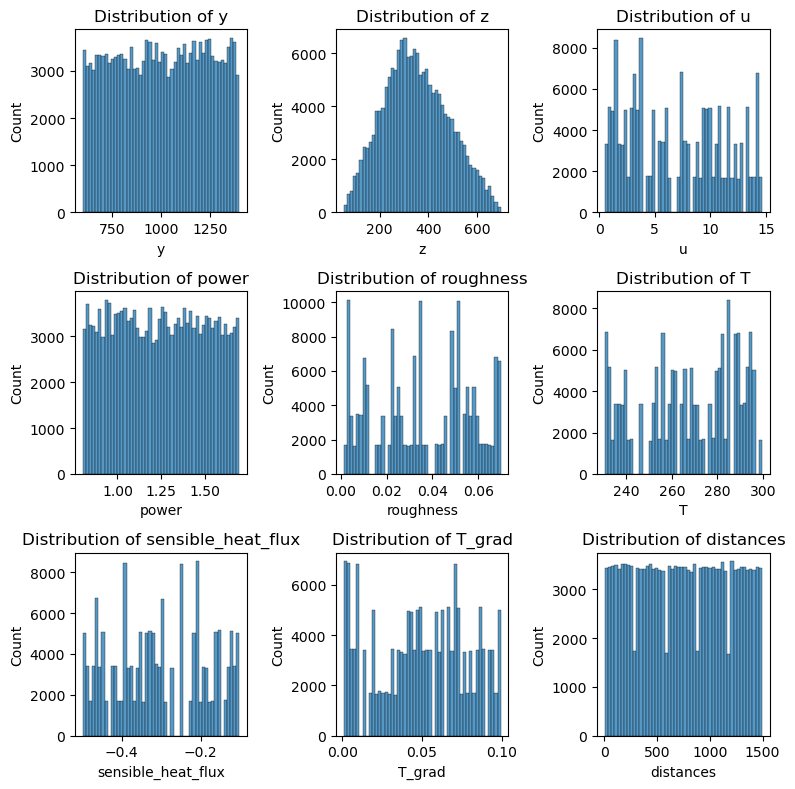

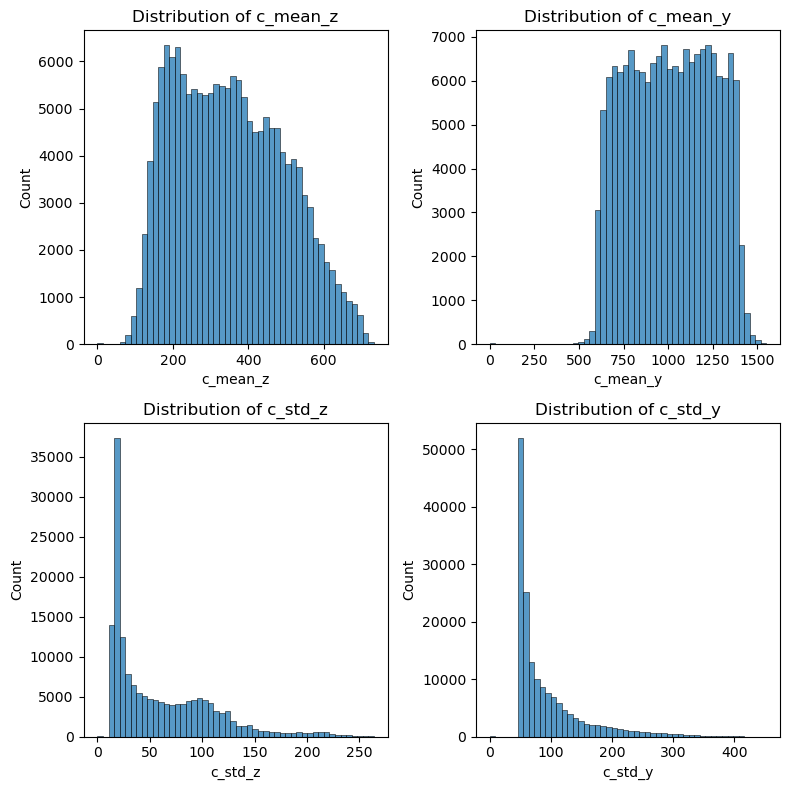

In [16]:
perform_eda_short(X_test, y_test)

## Feature engineering

In [25]:
#Delete zeros in train
X_train = X_train[y_train["c_std_y"] != 0]
X_train = X_train[y_train["c_std_z"] != 0]

y_train = y_train[y_train["c_std_z"] != 0]
y_train = y_train[y_train["c_std_y"] != 0]

NameError: name 'X_train' is not defined

In [18]:
#Delete zeros in test
X_test = X_test[y_test["c_std_y"] != 0]
X_test = X_test[y_test["c_std_z"] != 0]

y_test = y_test[y_test["c_std_z"] != 0]
y_test = y_test[y_test["c_std_y"] != 0]

/tmp/ipykernel_30692/2842488162.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = X_test[y_test["c_std_z"] != 0]


In [19]:
# for eval
X_eval = X_eval[y_eval["c_std_y"] != 0]
X_eval = X_eval[y_eval["c_std_z"] != 0]

y_eval = y_eval[y_eval["c_std_z"] != 0]
y_eval = y_eval[y_eval["c_std_y"] != 0]

/tmp/ipykernel_30692/2737467915.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_eval = X_eval[y_eval["c_std_z"] != 0]


In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

In [21]:

class TargetPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, near_zero = 1e-3):
        self.near_zero = near_zero

    def fit(self, data: pd.DataFrame, *args):
        self.columns = data.columns
        self.std_y_bias = np.min(data["c_std_y"])
        self.std_z_bias = np.min(data["c_std_z"])
        self.mean_y = np.mean(data["c_mean_y"])
        self.mean_z = np.mean(data["c_mean_z"])
        return self

    def transform(self, data: pd.DataFrame):
        data["c_std_y"] -= self.std_y_bias + self.near_zero
        data["c_std_z"] -= self.std_z_bias + self.near_zero
        data["c_std_y"] = np.log(data["c_std_y"])
        data["c_std_z"] = np.log(data["c_std_z"])

        data["c_mean_y"] -= self.mean_y + self.near_zero
        mean_y_sign =  np.sign(data["c_mean_y"])
        self.mean_y_sign = mean_y_sign
        data["c_mean_y"] = np.log(np.abs(data["c_mean_y"]))
        data["c_mean_y"] = data["c_mean_y"] * mean_y_sign

        data["c_mean_z"] -= self.mean_z + self.near_zero
        mean_z_sign =  np.sign(data["c_mean_z"])
        self.mean_z_sign = mean_z_sign
        data["c_mean_z"] = np.log(np.abs(data["c_mean_z"]))
        data["c_mean_z"] = data["c_mean_z"] * mean_z_sign
        return data
    
    def inverse_transform(self, data: pd.DataFrame):
        data["c_std_y"] = np.exp(data["c_std_y"])
        data["c_std_z"] = np.exp(data["c_std_z"])
        data["c_std_y"] += self.std_y_bias
        data["c_std_z"] += self.std_z_bias

        data["c_mean_y"] *= self.mean_y_sign
        data["c_mean_z"] *= self.mean_z_sign
        data["c_mean_y"] = np.exp(data["c_mean_y"])
        data["c_mean_z"] = np.exp(data["c_mean_z"])
        data["c_mean_y"] *= self.mean_y_sign
        data["c_mean_z"] *= self.mean_z_sign
        
        data["c_mean_y"] += self.mean_y
        data["c_mean_z"] += self.mean_z
        return data

## Models

### Constant model

In [30]:
y_pred = {}
for target in y_train.columns:
    y_pred[target] = np.mean(y_train[target]) * np.ones(len(y_test[target]))

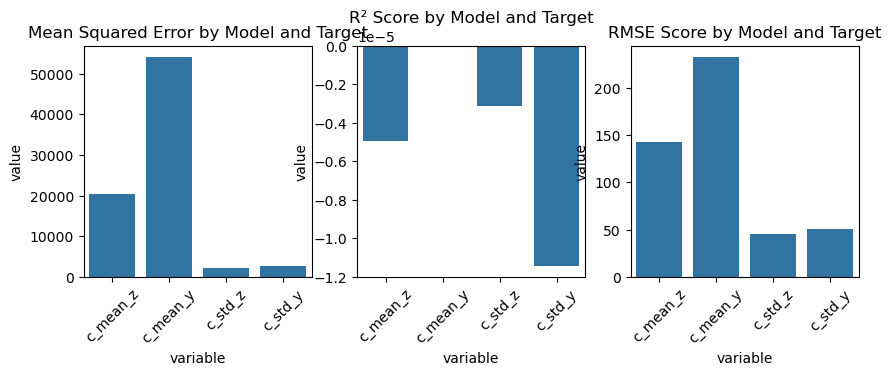

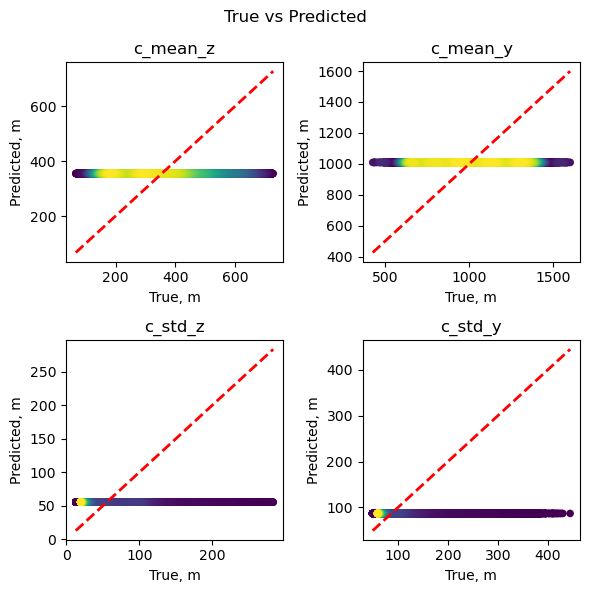

                   mse            r2        rmse
c_mean_z  20280.675802 -4.971877e-06  142.410238
c_mean_y  54134.050993 -2.352656e-08  232.667254
c_std_z    2081.263466 -3.150209e-06   45.620867
c_std_y    2595.019118 -1.143643e-05   50.941330


In [31]:
performance_visualizations(y_pred, y_test)

### Random model

In [32]:
y_pred = {}
for target in y_train.columns:
    print(np.min(y_train[target]),np.max(y_train[target]))
    y_pred[target] = np.random.normal(np.min(y_train[target]),np.max(y_train[target]), len(y_test))

66.65976376164568 726.8595831020261
414.6227668139376 1598.6048068447922
7.8125 283.8203062076564
49.30282017162916 445.9660853030433


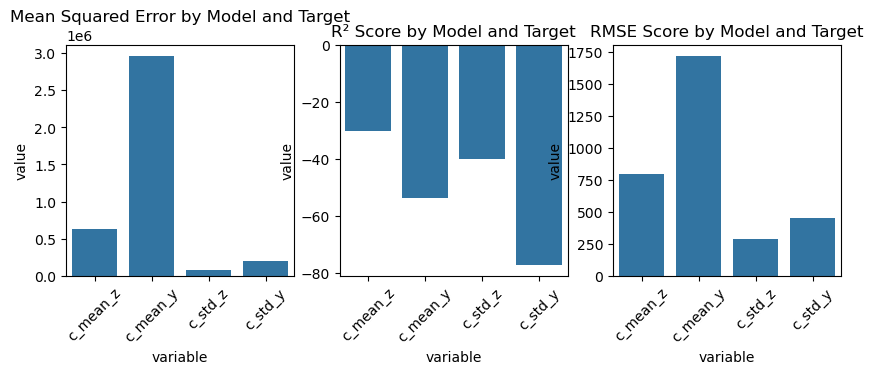

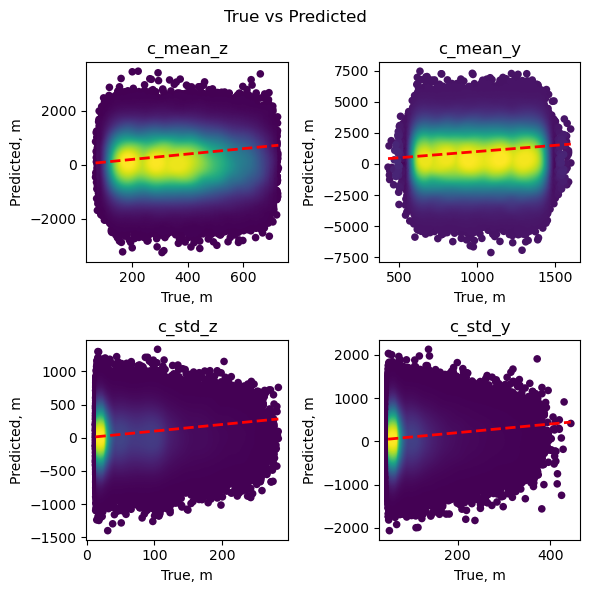

                   mse         r2         rmse
c_mean_z  6.300450e+05 -30.066425   793.753716
c_mean_y  2.963412e+06 -53.742105  1721.456317
c_std_z   8.510346e+04 -39.890415   291.724970
c_std_y   2.026191e+05 -77.080882   450.132273


In [33]:
performance_visualizations(y_pred, y_test)

## Catboost with optuna

In [31]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.02),
        'depth': trial.suggest_int('depth', 1, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 3.0),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'grow_policy': 'Depthwise',
        'iterations': 300,
        'use_best_model': True,
        'eval_metric': 'MultiRMSE',
        'loss_function': 'MultiRMSE',
        'od_type': 'iter',
        # 'task_type': "GPU",
        # 'devices': '0',
        'od_wait': 20,
        'random_state': random_seed,
        'logging_level': 'Silent'
    }
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=early_stopping_round)
    loss = root_mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
    return loss

In [32]:
# %%time
# study = optuna.create_study(study_name=f'catboost-seed{random_seed}')
# study.optimize(objective, n_trials=1000, n_jobs=-1, timeout=7200)

In [33]:
# print(study.best_value)
# print(study.best_params)

In [34]:
best_params = {'learning_rate': 0.0199640131584563, 'depth': 15, 'l2_leaf_reg': 1.8809696508799658, 'min_child_samples': 16}

In [35]:
params = {
    "learning_rate": best_params['learning_rate'],
    "depth": best_params['depth'],
    "l2_leaf_reg": best_params['l2_leaf_reg'],
    "min_child_samples": best_params['min_child_samples'],
    "grow_policy": 'Depthwise',
    "iterations": 1000,
    "use_best_model": True,
    "eval_metric": 'RMSE',
    "loss_function": 'RMSE',
    "thread_count": -1,
    "od_type": 'iter',
    "od_wait": 20,
    # "task_type":"GPU",
    # "devices":'0',
    "random_state": random_seed,
    "logging_level": 'Silent'
}   

In [36]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
%%time
y_pred ={}
regressors = {}
for target in ["c_mean_y", "c_mean_z"]:
    
    optimized_regressor = TransformedTargetRegressor(CatBoostRegressor(**params),
                                                    transformer = StandardScaler())

    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp 
    regressors[target] = optimized_regressor
for target in ["c_std_y", "c_std_z"]:
    
    optimized_regressor = TransformedTargetRegressor(CatBoostRegressor(**params),
                                                    func = np.log,
                                                    inverse_func=np.exp
                                                    )
    
    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp
    regressors[target] = optimized_regressor

In [ ]:
performance_visualizations(y_pred, y_test)

In [39]:
print(regressors["c_mean_y"].predict(specific_features))
print(regressors["c_std_y"].predict(specific_features))

[993.50081912]
[78.11997205]


In [35]:
rf_model = RandomForestRegressor(n_jobs=32)

In [36]:
y_pred = {}
for target in y_train.columns:
    rf_model.fit(X_train, y_train[target])
    y_tmp = rf_model.predict(X_test)
    y_pred[target] = y_tmp

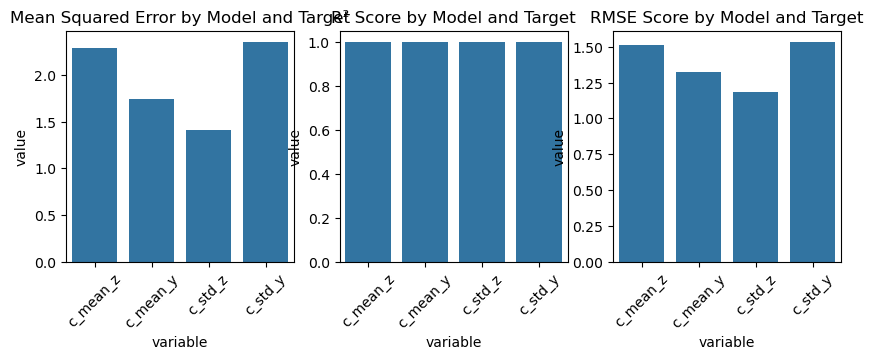

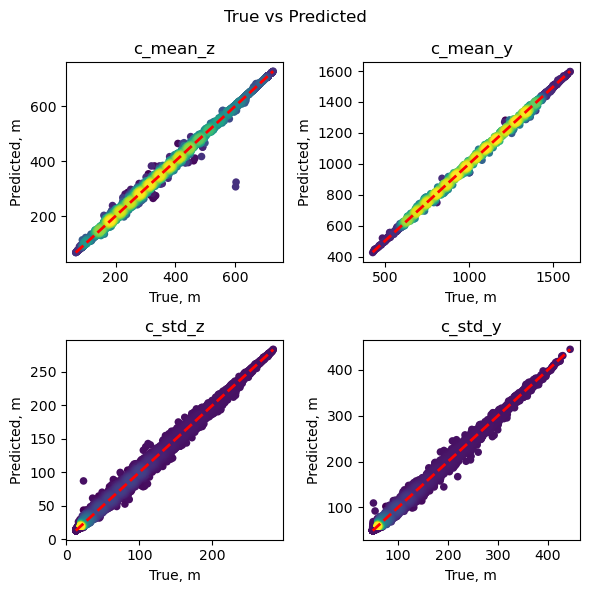

               mse        r2      rmse
c_mean_z  2.284803  0.999887  1.511556
c_mean_y  1.744530  0.999968  1.320807
c_std_z   1.407146  0.999324  1.186232
c_std_y   2.352697  0.999093  1.533850


In [38]:
performance_visualizations(y_pred, y_test)

## NN

In [32]:
from sklearn.neural_network import MLPRegressor

In [ ]:
%%time
y_pred ={}
for target in ["c_mean_y", "c_mean_z"]:
    
    mlp_regressor = TransformedTargetRegressor(MLPRegressor(),
                                                    transformer = StandardScaler())

    mlp_regressor.fit(X_train.copy(), y_train[target].copy())
    y_pred_tmp = mlp_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp 

for target in ["c_std_y", "c_std_z"]:
    
    mlp_regressor = TransformedTargetRegressor(MLPRegressor(),
                                                    func = np.log,
                                                    inverse_func=np.exp
                                                    )
    
    mlp_regressor.fit(X_train.copy(), y_train[target].copy())
    y_pred_tmp = mlp_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp

In [ ]:
performance_visualizations(y_pred, y_test)